In [8]:
from constants import *
from solver import SolveScheduling
from get_data import *
from train import * 
from models import *
from projectnet import *
import matplotlib.pyplot as plt

from exact_regularizer import RegApproximator
from parameters import *

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
params = {"n": 24, "c_ramp": 0.4, "gamma_under": 50, "gamma_over": 0.5}
scheduling_solver = SolvePointQP(params)
dist_solver = SolveScheduling(params)

X_train, Y_train, X_test, Y_test, X_train_pt, Y_train_pt, X_test_pt, Y_test_pt = get_data() 

In [3]:
def task_loss_no_quad(Y_sched, Y_actual, params):
    return (params["gamma_under"] * torch.clamp(Y_actual - Y_sched, min=0) + 
            params["gamma_over"] * torch.clamp(Y_sched - Y_actual, min=0)).mean()
def task_loss(Y_sched, Y_actual, params):
    return (params["gamma_under"] * torch.clamp(Y_actual - Y_sched, min=0) + 
            params["gamma_over"] * torch.clamp(Y_sched - Y_actual, min=0) + 0.5 * torch.square(Y_sched - Y_actual)).mean(0)

In [4]:
G = scheduling_solver.G[24*2:24*2+23*2,:]
A = torch.cat((G, torch.eye(G.shape[0]).to(DEVICE)), dim=1).float().to(DEVICE)
b = params['c_ramp'] * torch.ones((24 - 1)*2, device=DEVICE).float()

In [5]:
mle_net = Net(X_train[:,:-1], Y_train, [200,200]).to(DEVICE)
train_mle_net(mle_net, params, X_train_pt, Y_train_pt)

Net(
  (lin): Linear(in_features=149, out_features=24, bias=True)
  (net): Sequential(
    (0): Linear(in_features=149, out_features=200, bias=True)
    (1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=200, out_features=200, bias=True)
    (5): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=200, out_features=24, bias=True)
  )
)

In [6]:
Y_train_pt = mle_net(X_train_pt).detach()

In [9]:
learn_pnet = ProjectNet(A, b, 24, params, rounds=rounds, step=step_size).to(DEVICE)
train_projectnet(learn_pnet, Y_train_pt, params, lr=1e-3, epochs=500, verbose=True)

epoch  0  mean loss:  0.17587868267526993  median  0.16457729786634445 cur:  0.147096648812294
epoch  1  mean loss:  0.17299401879310608  median  0.16300896555185318 cur:  0.14896747469902039
epoch  2  mean loss:  0.17055035635828972  median  0.1635834500193596 cur:  0.12840333580970764
epoch  3  mean loss:  0.169000031799078  median  0.1614476963877678 cur:  0.14407867193222046
epoch  4  mean loss:  0.16743785083293916  median  0.15960760414600372 cur:  0.12963877618312836
epoch  5  mean loss:  0.1661447298526764  median  0.1593332216143608 cur:  0.12966853380203247
epoch  6  mean loss:  0.1657095442712307  median  0.159199520945549 cur:  0.12857624888420105
epoch  7  mean loss:  0.16566627085208893  median  0.1590614691376686 cur:  0.14176926016807556
epoch  8  mean loss:  0.16517056576907635  median  0.1587136834859848 cur:  0.12147196382284164
epoch  9  mean loss:  0.1643104577809572  median  0.1580636128783226 cur:  0.14515827596187592
epoch  10  mean loss:  0.16395485535264015  m

KeyboardInterrupt: 

In [32]:
opt_solutions = []
batch_size = 10
for k in range(0, (Y_train_pt.shape[0] // batch_size) * batch_size, batch_size):
    d = scheduling_solver(Y_train_pt[k:k+batch_size,:]).detach().cpu().numpy()
    opt_solutions.append(d)
opt_solutions = np.array(opt_solutions)
opt_solutions = np.array(opt_solutions).reshape(opt_solutions.shape[0] * opt_solutions.shape[1], 24)

In [33]:
reg_approximator = RegApproximator(opt_solutions)

In [34]:
# alpha = 0.1
# reg_approximator.linear_par(alpha, beta, verbose=True)

In [35]:
alpha = 0.1
beta = 0.2
opt_L = reg_approximator.get_quadratic_regularizer(alpha, beta, verbose=False)

In [36]:
np.round(opt_L, 4);

In [37]:
np.linalg.cond(opt_L)

1.0000064810702265

In [38]:
rho = 0.005

projectnet = ProjectNet(A, b, 24, params, rounds=100).to(DEVICE)
projectnet.Q = torch.tensor(opt_L).to(DEVICE).float()
projectnet.rho = rho

In [39]:
losses_fast = []
losses_vanilla = []
losses_learn = []
rs = range(5,20, 1)
l_rs = range(1,6)

for rounds in rs:
    outs = projectnet(Y_train_pt, rounds=rounds, xrho=0)
    l_vanilla = task_loss_no_quad(outs, Y_train_pt, params)
    
    outs = projectnet(Y_train_pt, rounds=rounds, xrho=rho)
    l = task_loss_no_quad(outs, Y_train_pt, params)
    
    losses_fast.append(l.item())
    losses_vanilla.append(l_vanilla.item())

for rounds in l_rs:
    outs = learn_pnet(Y_train_pt, rounds=rounds, learn=True)
    learn_l = task_loss_no_quad(outs, Y_train_pt, params)
    losses_learn.append(learn_l.item())


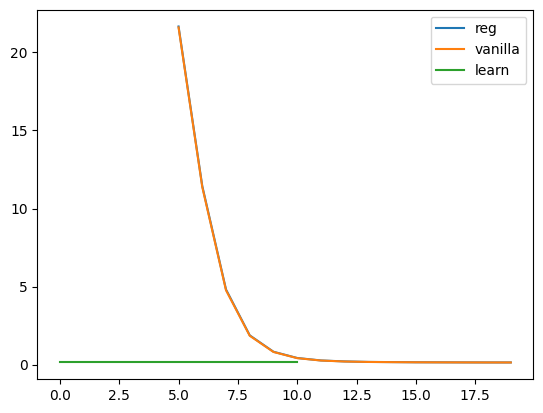

In [40]:
plt.plot(rs, losses_fast, label='reg')
plt.plot(rs, losses_vanilla, label='vanilla')
plt.plot([0,10], [losses_learn[-1],losses_learn[-1]] , label='learn')
plt.legend()
plt.show()

In [4]:
mle_net = Net(X_train[:,:-1], Y_train, [200,200]).to(DEVICE)
train_mle_net(mle_net, params, X_train_pt, Y_train_pt)

epoch: 0 loss: 0.17920169979333878 times: 0.3297889232635498
epoch: 1 loss: 0.15260260853056723 times: 0.22669458389282227
epoch: 2 loss: 0.13717754070575422 times: 0.19279257456461588
epoch: 3 loss: 0.12293945744633675 times: 0.17633122205734253
epoch: 4 loss: 0.10247148722410201 times: 0.16598954200744628
epoch: 5 loss: 0.09139559432864189 times: 0.15850265820821127
epoch: 6 loss: 0.08432182785123586 times: 0.152796847479684
epoch: 7 loss: 0.07917161662131549 times: 0.14940640330314636
epoch: 8 loss: 0.07453170385211706 times: 0.14724318186442056
epoch: 9 loss: 0.07093202453106642 times: 0.1444946527481079
epoch: 10 loss: 0.06707410674542189 times: 0.14248830621892755
epoch: 11 loss: 0.06395286597311496 times: 0.14069845279057822
epoch: 12 loss: 0.06120778292417526 times: 0.1396648333622859
epoch: 13 loss: 0.05867682598531246 times: 0.1384709051677159
epoch: 14 loss: 0.05686978280544281 times: 0.1373550573984782
epoch: 15 loss: 0.05479804515838623 times: 0.13629025220870972
epoch: 16

Net(
  (lin): Linear(in_features=149, out_features=24, bias=True)
  (net): Sequential(
    (0): Linear(in_features=149, out_features=200, bias=True)
    (1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=200, out_features=200, bias=True)
    (5): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=200, out_features=24, bias=True)
  )
)

In [7]:
rounds = 5

In [8]:
projectnet = ProjectNet(A, b, 24, rounds=rounds).to(DEVICE)
train_projectnet(projectnet, mle_net(X_train_pt).detach(), params, epochs=50, verbose=True)
torch.save(projectnet.state_dict(), "saved_models/projectnet{}.pt".format(params['c_ramp']))

epoch  0  mean loss:  4.18284008365411  median  3.9846460819244385 cur:  1.5376639366149902
epoch  1  mean loss:  2.721964291334152  median  2.080314874649048 cur:  1.2822952270507812
epoch  2  mean loss:  1.30033556163311  median  1.5520480275154114 cur:  0.6649987697601318
epoch  3  mean loss:  0.8545614406466484  median  1.2825250625610352 cur:  0.4993521571159363
epoch  4  mean loss:  0.596975120306015  median  1.0081420540809631 cur:  0.46785664558410645
epoch  5  mean loss:  0.45932706981897353  median  0.8250999748706818 cur:  0.42127329111099243
epoch  6  mean loss:  0.38493684962391855  median  0.6994702219963074 cur:  0.3650592267513275
epoch  7  mean loss:  0.3432394604384899  median  0.581022173166275 cur:  0.3170381188392639
epoch  8  mean loss:  0.3199559146165848  median  0.5299622118473053 cur:  0.31474143266677856
epoch  9  mean loss:  0.30364779233932493  median  0.47323331236839294 cur:  0.3098122179508209
epoch  10  mean loss:  0.289999230504036  median  0.437954962

In [66]:
# projectnet = ProjectNet(A, b, 24, rounds=5).to(DEVICE)
# projectnet.load_state_dict(torch.load("saved_models/projectnet{}.pt".format(params['c_ramp'])))

FileNotFoundError: [Errno 2] No such file or directory: 'saved_models/projectnet0.1.pt'

In [22]:
# projectnet.eval()
# model_pnet = Net(X_train[:,:-1], Y_train, [200,200]).to(DEVICE)
# train_with_pnet(model_pnet, projectnet, X_train_pt, Y_train_pt, params, rounds=rounds, epochs=50, lr=1e-4)

projectnet = ProjectNet(A, b, 24, rounds=rounds).to(DEVICE)
train_projectnet(projectnet, model_pnet(X_train_pt).detach(), params, epochs=50, verbose=True)
torch.save(projectnet.state_dict(), "saved_models/projectnet{}.pt".format(params['c_ramp']))

train_with_pnet(model_pnet, projectnet, X_train_pt, Y_train_pt, X_test_pt, Y_test_pt, params, rounds=rounds, epochs=50, lr=1e-4)
torch.save(model_pnet.state_dict(), "saved_models/model_pnet{}.pt".format(params['c_ramp']))

epoch  0  mean loss:  3.9755948392244487  median  3.781075954437256 cur:  1.3339604139328003
epoch  1  mean loss:  2.6845109701156615  median  2.1006016731262207 cur:  1.1829404830932617
epoch  2  mean loss:  1.4345572209358215  median  1.6450846195220947 cur:  0.7328975200653076
epoch  3  mean loss:  1.1463060581684112  median  1.4490913152694702 cur:  0.5920180082321167
epoch  4  mean loss:  0.9871708887815476  median  1.3116450309753418 cur:  0.46538084745407104
epoch  5  mean loss:  0.8187243214249611  median  1.177674412727356 cur:  0.3478233218193054
epoch  6  mean loss:  0.7040427184104919  median  1.068730354309082 cur:  0.3444867730140686
epoch  7  mean loss:  0.617328149676323  median  0.9836393892765045 cur:  0.25425514578819275
epoch  8  mean loss:  0.5436446094512939  median  0.8949326872825623 cur:  0.21643410623073578
epoch  9  mean loss:  0.5189338359236717  median  0.8517062962055206 cur:  0.2465420365333557
epoch  10  mean loss:  0.49954450339078904  median  0.7858456

In [7]:
# model_pnet = Net(X_train[:,:-1], Y_train, [200,200]).to(DEVICE)
# model_pnet.load_state_dict(torch.load("saved_models/model_pnet{}.pt".format(params['c_ramp'])))

<All keys matched successfully>

In [35]:
net_costs = []
batch_size = 100
for k in range(X_test_pt.shape[0] // batch_size):
    p = model_pnet(X_test_pt[k:k+batch_size,:]).detach()
    d = projectnet(p, rounds=5)
    cost_test = task_loss_no_mean(d, Y_test_pt[k:k+batch_size,:], params).detach().cpu().numpy()
    net_costs.append(cost_test)
    # test_costs.append(cost_test.item())

0.12967134

In [54]:
task_net = Net2(X_train[:,:-1], Y_train, [200,200]).to(DEVICE)
train_task_net(task_net, params, X_train_pt, Y_train_pt)
torch.save(task_net.state_dict(), "saved_models/task_net.pt")

epoch: 0 loss: 2.3861129613132053 times: 24.14952540397644
epoch: 1 loss: 2.1324610537095916 times: 23.861863136291504
epoch: 2 loss: 1.9182594444097503 times: 23.7902729511261
epoch: 3 loss: 1.6996734061814711 times: 24.037619590759277
epoch: 4 loss: 1.3475223767746587 times: 23.965864896774292
epoch: 5 loss: 1.0768389630970947 times: 23.944028735160828
epoch: 6 loss: 0.8743361698029382 times: 23.86519401414054
epoch: 7 loss: 0.7175933306379032 times: 23.74442908167839
epoch: 8 loss: 0.6053115277078343 times: 23.736521032121445
epoch: 9 loss: 0.5282188725486012 times: 23.688804364204408
epoch: 10 loss: 0.4696702816457084 times: 23.784093488346446
epoch: 11 loss: 0.4312673042086059 times: 23.800779183705647
epoch: 12 loss: 0.40697264646592557 times: 23.800506976934578
epoch: 13 loss: 0.3848881525097938 times: 23.80308427129473
epoch: 14 loss: 0.3756143836876597 times: 23.905430666605632
epoch: 15 loss: 0.37408408260234366 times: 23.87533275783062
epoch: 16 loss: 0.36698700728811107 tim

In [48]:
task_results = np.load("task_results.npy")
mle_results = np.load("mle_results.npy")

In [55]:
p_task, s_task = task_net(X_test_pt)
d_task = dist_solver(p_task, s_task).detach()
cost_task = task_loss_no_mean(d_task, Y_test_pt, params)

In [46]:
net_costs=np.array(net_costs).reshape(600,24)
net_costs.shape

(600, 24)

In [ ]:
plt.plot(range(24), np.mean(net_costs,axis=0), label='pnet')
# plt.plot(range(24), cost_task.mean(0).cpu().numpy(), label='task')
plt.plot(range(24), task_results[:600,:].mean(0), label='task')
# plt.plot(range(24), mle_results.mean(0), label='mle')
plt.legend()
plt.show()

In [43]:
torch.max(d[:,:23] - d[:,1:])

tensor(0.1000, device='cuda:0')

In [52]:
task_results.mean()

0.13162148

In [53]:
net_costs.mean()

0.12967134

In [55]:
# np.save("pnet_results.npy", net_costs)

In [66]:
def eval_model(model_pnet, projectnet):
    pnet_results = []
    for _ in range(10):
        net_costs = []
        for k in range(X_test_pt.shape[0] // batch_size):
            p = model_pnet(X_test_pt[k:k+batch_size,:]).detach()
            d = projectnet(p, rounds=rounds)
            cost_test = task_loss_no_mean(d, Y_test_pt[k:k+batch_size,:], params).detach().cpu().numpy()
            net_costs.append(cost_test)
        net_costs = np.array(net_costs).reshape(600,24)
        pnet_results.append(net_costs)
    pnet_results = np.array(pnet_results) 
    print(pnet_results[0,:])
    print(pnet_results[1,:])
    return np.mean(pnet_results, axis=0)


In [67]:
net_costs=eval_model(model_pnet, projectnet)

[[0.05169624 0.07740811 0.04036757 ... 0.18670538 0.22773585 0.17829044]
 [0.03361551 0.07978    0.03180664 ... 0.2716348  0.2717738  0.2556494 ]
 [0.09123388 0.5361624  0.16456479 ... 0.17476866 0.6277769  0.27443156]
 ...
 [0.0993123  0.1033532  0.07622579 ... 0.17429772 0.23094335 0.17656286]
 [0.07711309 0.08715592 0.0680978  ... 0.18661842 0.22768489 0.19754732]
 [0.07843082 0.06296031 0.06554107 ... 0.13948129 0.16330463 0.14074664]]
[[0.05169624 0.07740811 0.04036757 ... 0.18670538 0.22773585 0.17829044]
 [0.03361551 0.07978    0.03180664 ... 0.2716348  0.2717738  0.2556494 ]
 [0.09123388 0.5361624  0.16456479 ... 0.17476866 0.6277769  0.27443156]
 ...
 [0.0993123  0.1033532  0.07622579 ... 0.17429772 0.23094335 0.17656286]
 [0.07711309 0.08715592 0.0680978  ... 0.18661842 0.22768489 0.19754732]
 [0.07843082 0.06296031 0.06554107 ... 0.13948129 0.16330463 0.14074664]]


In [65]:
net_costs

array([[0.05169624, 0.0774081 , 0.04036757, ..., 0.18670537, 0.22773585,
        0.17829046],
       [0.03361552, 0.07978   , 0.03180664, ..., 0.2716348 , 0.2717738 ,
        0.25564936],
       [0.09123387, 0.5361624 , 0.1645648 , ..., 0.17476867, 0.627777  ,
        0.27443153],
       ...,
       [0.0993123 , 0.1033532 , 0.07622578, ..., 0.1742977 , 0.23094335,
        0.17656288],
       [0.07711309, 0.08715592, 0.06809781, ..., 0.18661843, 0.22768489,
        0.19754732],
       [0.07843082, 0.06296032, 0.06554108, ..., 0.13948129, 0.16330461,
        0.14074662]], dtype=float32)

In [72]:
import cplex

ModuleNotFoundError: No module named 'cplex'

In [74]:
import cvxpy as cp